beta [ 0.00000000e+00 -8.09881853e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.01696414e-01  0.00000000e+00  0.00000000e+00
 -3.61233162e-02 -1.55162785e-04  2.47967865e-03]
Mean Squared Error: 0.3195975250167373


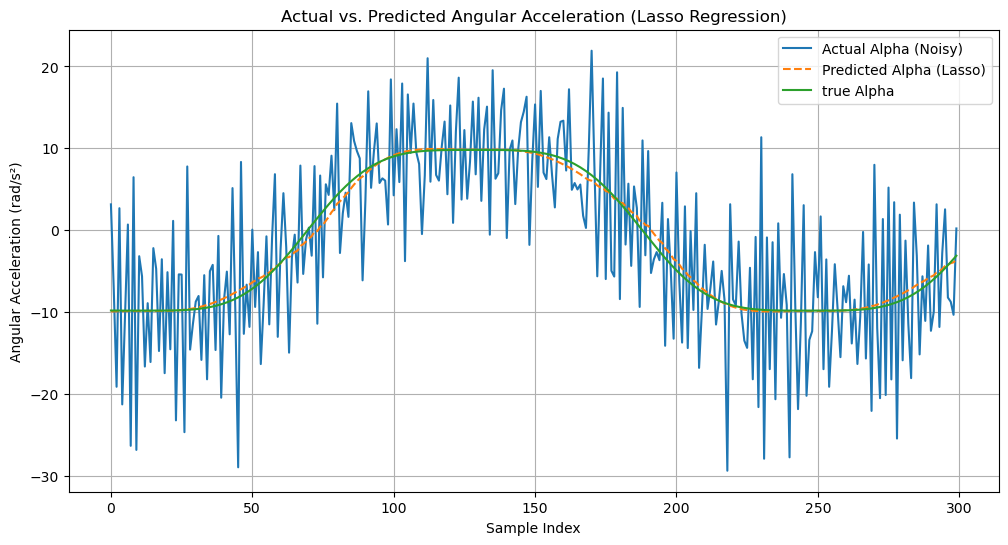

In [54]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

def my_lasso(A, y, lambd, max_iter):
    
    m, n = A.shape
    x = np.zeros(n)

    for _ in range(max_iter):
        for j in range(n):
            r = y - A @ x + A[:, j]*x[j]

            A_j = A[:, j]
            col_norm = A_j @ A_j
            val = A_j @ r

            # Soft-thresholding step
            if val > lambd:
                x[j] = (val - lambd) / col_norm
            elif val < -lambd:
                x[j] = (val + lambd) / col_norm
            else:
                x[j] = 0.0

    return x





# Parameters
g = 9.81      # Acceleration due to gravity (m/s²)
L = 1.0       # Length of the pendulum (m)
dt = 0.01     # Time step (s)
t_max = 10    # Total time (s)
t = np.arange(0, t_max + dt, dt)  # Time array

# Differential equations
def pendulum_derivatives(y, t, g, L):
    theta, omega = y
    dydt = [omega, -(g / L) * np.sin(theta)]
    return dydt

# Initial conditions
initial_theta = np.pi / 2
initial_omega = 0
y0 = [initial_theta, initial_omega]

# Integrate the ODEs
solution = odeint(pendulum_derivatives, y0, t, args=(g, L))

# Extract true theta and omega
theta_true = solution[:, 0]
omega_true = solution[:, 1]

# Calculate true alpha
alpha_true = -(g / L) * np.sin(theta_true)

# Set random seed
np.random.seed(33)

# Add noise to omega
noise_level = 0.02  # 1%
omega_std = np.std(omega_true)
noise_omega = noise_level * omega_std * np.random.randn(len(omega_true))
omega_noisy = omega_true + noise_omega

# Calculate theta_noisy by integrating omega_noisy
theta_noisy = np.zeros_like(omega_noisy)
theta_noisy[0] = initial_theta  # Initial condition
theta_noisy[1:] = initial_theta + np.cumsum((omega_noisy[:-1] + omega_noisy[1:]) / 2 * dt)

# Calculate alpha_noisy using backward differences
alpha_noisy = np.zeros_like(omega_noisy)
alpha_noisy[0] = (omega_noisy[0] - initial_omega) / dt  # Using initial omega
alpha_noisy[1:] = (omega_noisy[1:] - omega_noisy[:-1]) / dt

# Decide on the maximum power n
n = 5

# Initialize the feature matrix with ones (intercept term)
X = np.ones((len(theta_noisy), 1))

# Add polynomial terms of theta_noisy
for i in range(1, n + 1):
    X = np.hstack((X, (theta_noisy ** i).reshape(-1, 1)))

#Add polynomial terms of omega_noisy
for i in range(1, n + 1):
    X = np.hstack((X, (omega_noisy ** i).reshape(-1, 1)))



# Target variable
y = alpha_noisy

# Split the data into training and testing sets
X_train = X[:700]
X_test = X[700:1000]
y_train = y[:700]
y_test = y[700:1000]

# Perform Lasso regression
beta = my_lasso(X_train,y_train,100,max_iter=10000)
y_test_pred = np.dot(X_test, beta) 
print("beta",beta)
y_true = alpha_true[700:1000]

# MSE error 
mse = np.mean((y_true - y_test_pred) ** 2)
print("Mean Squared Error:", mse)
# Plot actual vs predicted alpha on testing set
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Alpha (Noisy)')
plt.plot(range(len(y_test_pred)),y_test_pred, label='Predicted Alpha (Lasso)', linestyle='--')
plt.plot(range(len(y_true)), y_true, label='true Alpha')
plt.xlabel('Sample Index')
plt.ylabel('Angular Acceleration (rad/s²)')
plt.title('Actual vs. Predicted Angular Acceleration (Lasso Regression)')
plt.legend()
plt.grid(True)
plt.show()


y =  [17 39]
